# Extracting Human Faces From Images

## Imports

In [3]:
import cv2 
import getch
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd
import random

from huggingface_hub import hf_hub_download
from IPython.display import clear_output
from PIL import Image
from supervision import Detections
from ultralytics.engine.results import Results
from ultralytics import YOLO

/home/pooh/miniconda3/envs/deep_learning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Constants

In [4]:
# Dataset paths
dataset_path = "dataset"
train_csv_path = "dataset/train.csv"
test_csv_path = "dataset/test.csv"

## Data Preprocessing

In [5]:
# loading annotation files
train_csv = pd.read_csv(train_csv_path)
test_csv = pd.read_csv(test_csv_path)

In [6]:
train_csv.head()

,Unnamed: 0,file_name,label
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [7]:
test_csv.head()

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


## Use Model

In [8]:
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")
model = YOLO(model_path)

## Test

In [ ]:
image_paths = train_csv["file_name"].tolist()
image_labels = train_csv["label"].tolist()

In [ ]:
len(image_paths)

5540

In [ ]:
len(image_labels)

In [ ]:
for j in range(len(image_paths)):
    original_image_bgr = cv2.imread(os.path.join(dataset_path, image_paths[j]))
        
    if original_image_bgr is None:
        print(f"Error: Could not load image from path: {os.path.join(dataset_path, image_paths[j])}")
        exit() 
    else:
        print(f"Image loaded successfully: {os.path.join(dataset_path, image_paths[j])}")

        output: list[Results] = model(original_image_bgr) # Pass the BGR image array
        results_ultralytics: Results = output[0] # Get results for the first (only) image

        # Access the bounding boxes (xyxy format) from the results
        # .cpu() moves tensor to CPU, .numpy() converts to NumPy array
        bboxes_xyxy = results_ultralytics.boxes.xyxy.cpu().numpy()
        confidences = results_ultralytics.boxes.conf.cpu().numpy()

        # Define the directory to save cropped faces
        if image_labels[j] == 0:
            output_crop_dir = "cropped_faces_dataset/human"
        if image_labels[j] == 1:
            output_crop_dir = "cropped_faces_dataset/AI"

        os.makedirs(output_crop_dir, exist_ok=True) # Create directory if it doesn't exist

        # Define a base name for the output files
        base_filename = os.path.splitext(os.path.basename(os.path.join(dataset_path, image_paths[j])))[0]

        print("Original image: ", j)
        print(f"Found {len(bboxes_xyxy)} face(s). Cropping and saving...")

        if len(bboxes_xyxy) > 0:
            for i, (bbox, confidence) in enumerate(zip(bboxes_xyxy, confidences)):
                if confidence > 0.69:
                    # Extract integer coordinates (xmin, ymin, xmax, ymax)
                    x_min, y_min, x_max, y_max = map(int, bbox[:4])

                    # Add padding or ensure coordinates are within bounds if necessary (optional)
                    padding = 0
                    h, w = original_image_bgr.shape[:2]
                    x_min = max(0, x_min - padding)
                    y_min = max(0, y_min - padding)
                    x_max = min(w, x_max + padding)
                    y_max = min(h, y_max + padding)

                    # Crop the face region from the original BGR image using NumPy slicing
                    cropped_face_bgr = original_image_bgr[y_min:y_max, x_min:x_max]

                    # Check if the crop is valid (has width and height)
                    if cropped_face_bgr.shape[0] > 64 and cropped_face_bgr.shape[1] > 64:
                        cropped_face_rgb = cv2.cvtColor(cropped_face_bgr, cv2.COLOR_BGR2RGB)
                        cropped_face_pil = Image.fromarray(cropped_face_rgb)
                        output_crop_path = os.path.join(output_crop_dir, f"{base_filename}_face{i}.jpg")

                        # Save the cropped face image
                        cropped_face_pil.save(output_crop_path)
                        
                        # print(f"Saved cropped face {i} (confidence: {confidence:.2f}) to: {output_crop_path}")
                    else:
                        print(f"Warning: Skipped saving face {i} (confidence: {confidence:.2f}) due to invalid dimensions after cropping.")
                else:
                    print(f"Skipping face {i} with confidence {confidence:.2f} (below threshold of 0.69).")
            
        else:
            print("No faces were detected in the image.")

        

Image loaded successfully: dataset/train_data/a6dcb93f596a43249135678dfcfc17ea.jpg

0: 640x448 2 FACEs, 4.4ms
Speed: 1.2ms preprocess, 4.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)
Original image:  0
Found 2 face(s). Cropping and saving...
Image loaded successfully: dataset/train_data/041be3153810433ab146bc97d5af505c.jpg

0: 640x448 2 FACEs, 4.6ms
Speed: 1.1ms preprocess, 4.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)
Original image:  1
Found 2 face(s). Cropping and saving...
Image loaded successfully: dataset/train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg

0: 448x640 1 FACE, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)
Original image:  2
Found 1 face(s). Cropping and saving...
Image loaded successfully: dataset/train_data/8542fe161d9147be8e835e50c0de39cd.jpg

0: 448x640 1 FACE, 4.7ms
Speed: 1.3ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)
O

## For Testing (ignore)

Image loaded successfully: dataset/train_data/dfe6f75257654f74bf65c54a3f7f41e9.jpg

0: 448x640 1 FACE, 4.6ms
Speed: 1.4ms preprocess, 4.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)
Original image:  11599
Found 1 face(s). Cropping and saving...


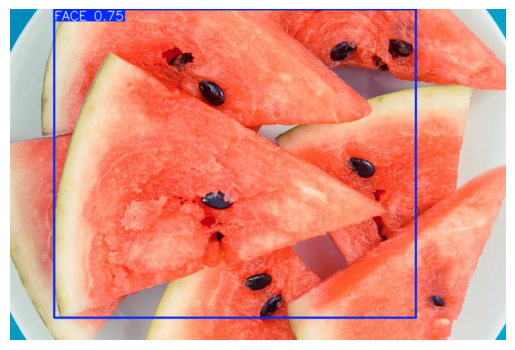

ValueError: invalid literal for int() with base 10: ''

In [ ]:
# isContinue = 0

# isContinue = int(input("Continue (0 exit | 1 continue): "))

# # for j in range(len(image_paths)):
# while (isContinue):
#     clear_output(wait=True)

#     # temporary variable for testing !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#     j = random.randint(0, 79949)
#     original_image_bgr = cv2.imread(os.path.join(dataset_path, image_paths[j]))
        
#     if original_image_bgr is None:
#         print(f"Error: Could not load image from path: {os.path.join(dataset_path, image_paths[j])}")
#         exit() 
#     else:
#         print(f"Image loaded successfully: {os.path.join(dataset_path, image_paths[j])}")

#         output: list[Results] = model(original_image_bgr) # Pass the BGR image array
#         results_ultralytics: Results = output[0] # Get results for the first (only) image

#         # Access the bounding boxes (xyxy format) from the results
#         # .cpu() moves tensor to CPU, .numpy() converts to NumPy array
#         bboxes_xyxy = results_ultralytics.boxes.xyxy.cpu().numpy()
#         confidences = results_ultralytics.boxes.conf.cpu().numpy()

#         # Define the directory to save cropped faces
#         if image_labels[j] == 0:
#             output_crop_dir = "cropped_faces_dataset/human"
#         if image_labels[j] == 1:
#             output_crop_dir = "cropped_faces_dataset/AI"

#         os.makedirs(output_crop_dir, exist_ok=True) # Create directory if it doesn't exist

#         # Define a base name for the output files
#         base_filename = os.path.splitext(os.path.basename(os.path.join(dataset_path, image_paths[j])))[0]

#         print("Original image: ", j)
#         print(f"Found {len(bboxes_xyxy)} face(s). Cropping and saving...")

#         if len(bboxes_xyxy) > 0:
#             for i, (bbox, confidence) in enumerate(zip(bboxes_xyxy, confidences)):
#                 if confidence > 0.69:
#                     # Extract integer coordinates (xmin, ymin, xmax, ymax)
#                     x_min, y_min, x_max, y_max = map(int, bbox[:4])

#                     # Add padding or ensure coordinates are within bounds if necessary (optional)
#                     padding = 0
#                     h, w = original_image_bgr.shape[:2]
#                     x_min = max(0, x_min - padding)
#                     y_min = max(0, y_min - padding)
#                     x_max = min(w, x_max + padding)
#                     y_max = min(h, y_max + padding)

#                     # Crop the face region from the original BGR image using NumPy slicing
#                     cropped_face_bgr = original_image_bgr[y_min:y_max, x_min:x_max]

#                     # Check if the crop is valid (has width and height)
#                     if cropped_face_bgr.shape[0] > 64 and cropped_face_bgr.shape[1] > 64:
#                         cropped_face_rgb = cv2.cvtColor(cropped_face_bgr, cv2.COLOR_BGR2RGB)
#                         cropped_face_pil = Image.fromarray(cropped_face_rgb)
#                         output_crop_path = os.path.join(output_crop_dir, f"{base_filename}_face{i}.jpg")

#                         # ----------------------------------------------------------------------------
#                         annotated_image_bgr: np.ndarray = results_ultralytics.plot(conf=True, labels=True)
#                         annotated_image_rgb = cv2.cvtColor(annotated_image_bgr, cv2.COLOR_BGR2RGB)
                        
#                         plt.imshow(annotated_image_rgb)
#                         plt.axis("off")
#                         plt.show(block=False)

#                         isContinue = int(input("Continue (0 exit | 1 continue): "))

#                         plt.close()
#                         # ----------------------------------------------------------------------------

#                         # Save the cropped face image
#                         cropped_face_pil.save(output_crop_path)
#                         print(f"Saved cropped face {i} (confidence: {confidence:.2f}) to: {output_crop_path}")
#                     else:
#                         print(f"Warning: Skipped saving face {i} (confidence: {confidence:.2f}) due to invalid dimensions after cropping.")
#                 else:
#                     print(f"Skipping face {i} with confidence {confidence:.2f} (below threshold of 0.69).")
            
#         else:
#             print("No faces were detected in the image.")

        